In [1]:
import os
import cv2
import shutil

import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split, DataLoader
from torchvision.utils import make_grid, save_image
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
import torchvision.transforms as T

import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'


In [2]:
# Define image transformations
transform = T.Compose([
    T.Resize(64),
    T.CenterCrop(64),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Download and load the dataset
dataset = CIFAR10(root='data/', download=True, transform=transform)

# Create a DataLoader
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


100%|██████████| 170M/170M [00:03<00:00, 53.0MB/s] 


Extracting data/cifar-10-python.tar.gz to data/


In [3]:
# Define image transformations
transform = T.Compose([
    T.Resize(64),
    T.CenterCrop(64),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Download and load the dataset
dataset = CIFAR10(root='data/', download=True, transform=transform)

# Create a DataLoader
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


Files already downloaded and verified


In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.text_emb = nn.Sequential(
            nn.Linear(119, 256),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(100 + 256, 4 * 4 * 512)
        )
        
        self.net = nn.Sequential(
            nn.BatchNorm2d(512, momentum=0.9),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(256, momentum=0.9),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(128, momentum=0.9),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d(64, momentum=0.9),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.Tanh()
        )
        
    def forward(self, noise, text_input):
        text_emb = self.text_emb(text_input)
        x = torch.cat([noise, text_emb], dim=1)
        x = self.fc(x)
        x = x.view(-1, 512, 4, 4)
        x = self.net(x)
        return x


In [5]:
class DiscriminatorWGAN(nn.Module):
    def __init__(self):
        super(DiscriminatorWGAN, self).__init__()
        
        self.text_emb = nn.Sequential(
            nn.Linear(119, 256),
            nn.ReLU()
        )
        
        self.image_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        
        self.final_net = nn.Sequential(
            nn.Conv2d(512 + 256, 512, kernel_size=1, stride=1),
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1)
        )
        
    def forward(self, image_input, text_input):
        text_emb = self.text_emb(text_input)
        text_emb = text_emb.view(-1, 256, 1, 1)
        text_emb = text_emb.repeat(1, 1, 4, 4)
        image_feat = self.image_net(image_input)
        combined = torch.cat([image_feat, text_emb], dim=1)
        output = self.final_net(combined)
        return output


In [6]:
def gradient_penalty(discriminator, real_data, fake_data, text_input):
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1, 1, 1, device=device)
    interpolated = epsilon * real_data + (1 - epsilon) * fake_data
    interpolated.requires_grad_(True)
    prob_interpolated = discriminator(interpolated, text_input)
    
    gradients = torch.autograd.grad(
        outputs=prob_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones(prob_interpolated.size(), device=device),
        create_graph=True,
        retain_graph=True
    )[0]
    
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    gp = ((gradient_norm - 1) ** 2).mean()
    return gp


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [9]:
# Create instances of the models
generator = Generator().to(device)
discriminator = DiscriminatorWGAN().to(device)

# Optimizers
lr = 0.0002
beta1 = 0.5
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))


In [10]:
def train_wgan(num_epochs):
    generator.train()
    discriminator.train()
    total_step = len(dataloader)
    lambda_gp = 10  # Gradient penalty lambda
    n_critic = 5  # Number of critic iterations per generator iteration
    for epoch in range(num_epochs):
        for i, (images, _) in enumerate(dataloader):
            batch_size_curr = images.size(0)
            images = images.to(device)
            text_inputs = torch.randn(batch_size_curr, 119, device=device)
            
            # Train Discriminator
            for _ in range(n_critic):
                discriminator.zero_grad()
                
                # Real images
                real_outputs = discriminator(images, text_inputs)
                d_loss_real = -torch.mean(real_outputs)
                
                # Fake images
                noise = torch.randn(batch_size_curr, 100, device=device)
                fake_images = generator(noise, text_inputs)
                fake_outputs = discriminator(fake_images.detach(), text_inputs)
                d_loss_fake = torch.mean(fake_outputs)
                
                # Gradient penalty
                gp = gradient_penalty(discriminator, images.data, fake_images.data, text_inputs)
                
                # Total discriminator loss
                d_loss = d_loss_real + d_loss_fake + lambda_gp * gp
                d_loss.backward()
                d_optimizer.step()
            
            # Train Generator
            generator.zero_grad()
            
            # Generate fake images
            noise = torch.randn(batch_size_curr, 100, device=device)
            fake_images = generator(noise, text_inputs)
            fake_outputs = discriminator(fake_images, text_inputs)
            g_loss = -torch.mean(fake_outputs)
            
            # Backprop and optimize
            g_loss.backward()
            g_optimizer.step()
            
            # Print log info
            if (i+1) % 200 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], '
                      f'D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}')
        
        # Save generated images
        save_fake_images(epoch+1)


In [12]:
def save_fake_images(epoch):
    generator.eval()
    with torch.no_grad():
        fixed_noise = torch.randn(64, 100, device=device)
        fixed_text = torch.randn(64, 119, device=device)
        fake_images = generator(fixed_noise, fixed_text)
        fake_images = (fake_images + 1) / 2  # Rescale to [0,1]
        save_image(fake_images, f'fake_images_epoch_{epoch}.png', nrow=8)
    generator.train()


In [13]:
def generate_and_display_images(model, num_images=16):
    model.eval()
    with torch.no_grad():
        noise = torch.randn(num_images, 100, device=device)
        text_inputs = torch.randn(num_images, 119, device=device)
        fake_images = model(noise, text_inputs)
        fake_images = (fake_images + 1) / 2  # Rescale to [0,1]
        grid = make_grid(fake_images.cpu(), nrow=4)
        plt.figure(figsize=(8, 8))
        plt.imshow(grid.permute(1, 2, 0).numpy())
        plt.axis('off')
        plt.show()
    model.train()


In [15]:
num_epochs = 50
train_wgan(num_epochs)


Epoch [1/50], Step [200/782], D Loss: -1.2957, G Loss: -43.6291
Epoch [1/50], Step [400/782], D Loss: 0.5115, G Loss: -45.3562
Epoch [1/50], Step [600/782], D Loss: 0.7953, G Loss: -76.4633
Epoch [2/50], Step [200/782], D Loss: -2.6755, G Loss: -279.2583
Epoch [2/50], Step [400/782], D Loss: -4.7892, G Loss: -64.1716
Epoch [2/50], Step [600/782], D Loss: 1.4185, G Loss: -96.3885
Epoch [3/50], Step [200/782], D Loss: 1.7651, G Loss: 20.5559
Epoch [3/50], Step [400/782], D Loss: -4.4261, G Loss: 217.7518
Epoch [3/50], Step [600/782], D Loss: -2.1446, G Loss: 34.6482
Epoch [4/50], Step [200/782], D Loss: -3.7368, G Loss: 79.2826
Epoch [4/50], Step [400/782], D Loss: 1.2461, G Loss: -29.3307
Epoch [4/50], Step [600/782], D Loss: -1.9097, G Loss: -59.9506
Epoch [5/50], Step [200/782], D Loss: -7.3201, G Loss: 105.0891
Epoch [5/50], Step [400/782], D Loss: -7.3700, G Loss: -424.0858
Epoch [5/50], Step [600/782], D Loss: -1.2834, G Loss: 61.4749
Epoch [6/50], Step [200/782], D Loss: -0.5476, 

In [16]:
training_output = """
Epoch [1/50], Step [200/782], D Loss: -1.2957, G Loss: -43.6291
Epoch [1/50], Step [400/782], D Loss: 0.5115, G Loss: -45.3562
Epoch [1/50], Step [600/782], D Loss: 0.7953, G Loss: -76.4633
Epoch [2/50], Step [200/782], D Loss: -2.6755, G Loss: -279.2583
Epoch [2/50], Step [400/782], D Loss: -4.7892, G Loss: -64.1716
Epoch [2/50], Step [600/782], D Loss: 1.4185, G Loss: -96.3885
Epoch [3/50], Step [200/782], D Loss: 1.7651, G Loss: 20.5559
Epoch [3/50], Step [400/782], D Loss: -4.4261, G Loss: 217.7518
Epoch [3/50], Step [600/782], D Loss: -2.1446, G Loss: 34.6482
Epoch [4/50], Step [200/782], D Loss: -3.7368, G Loss: 79.2826
Epoch [4/50], Step [400/782], D Loss: 1.2461, G Loss: -29.3307
Epoch [4/50], Step [600/782], D Loss: -1.9097, G Loss: -59.9506
Epoch [5/50], Step [200/782], D Loss: -7.3201, G Loss: 105.0891
Epoch [5/50], Step [400/782], D Loss: -7.3700, G Loss: -424.0858
Epoch [5/50], Step [600/782], D Loss: -1.2834, G Loss: 61.4749
Epoch [6/50], Step [200/782], D Loss: -0.5476, G Loss: 281.8912
Epoch [6/50], Step [400/782], D Loss: 0.6589, G Loss: 17.5178
Epoch [6/50], Step [600/782], D Loss: 0.5140, G Loss: 78.1130
Epoch [7/50], Step [200/782], D Loss: -0.4257, G Loss: -13.2117
Epoch [7/50], Step [400/782], D Loss: 1.7353, G Loss: -8.0143
Epoch [7/50], Step [600/782], D Loss: -15.1388, G Loss: -100.3327
Epoch [8/50], Step [200/782], D Loss: -0.3325, G Loss: 24.1142
Epoch [8/50], Step [400/782], D Loss: 0.9051, G Loss: -13.4325
Epoch [8/50], Step [600/782], D Loss: -4.0737, G Loss: 76.3490
Epoch [9/50], Step [200/782], D Loss: -2.7376, G Loss: 90.1962
Epoch [9/50], Step [400/782], D Loss: -1.5875, G Loss: -26.5839
Epoch [9/50], Step [600/782], D Loss: -0.2869, G Loss: -163.0814
Epoch [10/50], Step [200/782], D Loss: -0.5053, G Loss: 555.2203
Epoch [10/50], Step [400/782], D Loss: 0.9732, G Loss: 168.3967
Epoch [10/50], Step [600/782], D Loss: -0.7229, G Loss: -47.9422
Epoch [11/50], Step [200/782], D Loss: -1.8349, G Loss: -63.2941
Epoch [11/50], Step [400/782], D Loss: 0.4742, G Loss: 66.9536
Epoch [11/50], Step [600/782], D Loss: -4.9365, G Loss: 21.7864
Epoch [12/50], Step [200/782], D Loss: 0.8302, G Loss: -1.5416
Epoch [12/50], Step [400/782], D Loss: -1.7031, G Loss: 25.9708
Epoch [12/50], Step [600/782], D Loss: -0.8343, G Loss: 52.1682
Epoch [13/50], Step [200/782], D Loss: -3.1543, G Loss: -227.2336
Epoch [13/50], Step [400/782], D Loss: -1.4221, G Loss: 89.7421
Epoch [13/50], Step [600/782], D Loss: -1.1256, G Loss: -72.9341
Epoch [14/50], Step [200/782], D Loss: -0.8187, G Loss: 89.3700
Epoch [14/50], Step [400/782], D Loss: -1.6433, G Loss: -54.4169
Epoch [14/50], Step [600/782], D Loss: -2.5192, G Loss: -17.5381
Epoch [15/50], Step [200/782], D Loss: -0.9158, G Loss: -118.1607
Epoch [15/50], Step [400/782], D Loss: -1.5910, G Loss: 63.7069
Epoch [15/50], Step [600/782], D Loss: -2.3059, G Loss: 147.5509
Epoch [16/50], Step [200/782], D Loss: -0.8566, G Loss: -84.1354
Epoch [16/50], Step [400/782], D Loss: -8.7240, G Loss: 59.1080
Epoch [16/50], Step [600/782], D Loss: -0.3851, G Loss: 34.7514
Epoch [17/50], Step [200/782], D Loss: 1.1376, G Loss: 284.0542
Epoch [17/50], Step [400/782], D Loss: -3.8011, G Loss: -4.9117
Epoch [17/50], Step [600/782], D Loss: -8.5876, G Loss: 169.2684
Epoch [18/50], Step [200/782], D Loss: -0.9546, G Loss: 52.7945
Epoch [18/50], Step [400/782], D Loss: -0.5596, G Loss: 33.8140
Epoch [18/50], Step [600/782], D Loss: -7.7047, G Loss: 149.6183
Epoch [19/50], Step [200/782], D Loss: -1.8937, G Loss: 8.5124
Epoch [19/50], Step [400/782], D Loss: -0.5822, G Loss: -184.4408
Epoch [19/50], Step [600/782], D Loss: -4.2182, G Loss: 123.1563
Epoch [20/50], Step [200/782], D Loss: -1.2251, G Loss: -53.2139
Epoch [20/50], Step [400/782], D Loss: -3.0201, G Loss: -137.8481
Epoch [20/50], Step [600/782], D Loss: -2.6483, G Loss: -252.2294
Epoch [21/50], Step [200/782], D Loss: 0.2715, G Loss: 0.6385
Epoch [21/50], Step [400/782], D Loss: -6.5436, G Loss: -210.8075
Epoch [21/50], Step [600/782], D Loss: -0.0334, G Loss: 119.2902
Epoch [22/50], Step [200/782], D Loss: -1.9507, G Loss: 129.5504
Epoch [22/50], Step [400/782], D Loss: -0.7423, G Loss: -95.0986
Epoch [22/50], Step [600/782], D Loss: -2.4906, G Loss: -83.5221
Epoch [23/50], Step [200/782], D Loss: -1.4339, G Loss: 54.2353
Epoch [23/50], Step [400/782], D Loss: -3.3339, G Loss: 50.8033
Epoch [23/50], Step [600/782], D Loss: 2.1938, G Loss: 119.5547
Epoch [24/50], Step [200/782], D Loss: -3.4433, G Loss: -32.8455
Epoch [24/50], Step [400/782], D Loss: -6.7995, G Loss: -38.4105
Epoch [24/50], Step [600/782], D Loss: -0.6480, G Loss: -24.3574
Epoch [25/50], Step [200/782], D Loss: -0.4517, G Loss: 0.1404
Epoch [25/50], Step [400/782], D Loss: -4.9269, G Loss: -264.1995
Epoch [25/50], Step [600/782], D Loss: -1.8558, G Loss: -238.3064
Epoch [26/50], Step [200/782], D Loss: -3.4477, G Loss: -230.1125
Epoch [26/50], Step [400/782], D Loss: -2.0479, G Loss: 12.5674
Epoch [26/50], Step [600/782], D Loss: -1.5543, G Loss: 121.1706
Epoch [27/50], Step [200/782], D Loss: -1.9706, G Loss: -67.2339
Epoch [27/50], Step [400/782], D Loss: 0.8343, G Loss: -13.8644
Epoch [27/50], Step [600/782], D Loss: -2.2073, G Loss: 235.3438
Epoch [28/50], Step [200/782], D Loss: -3.8290, G Loss: 130.8418
Epoch [28/50], Step [400/782], D Loss: -0.4075, G Loss: 2.7935
Epoch [28/50], Step [600/782], D Loss: 0.7480, G Loss: -110.0027
Epoch [29/50], Step [200/782], D Loss: -1.7129, G Loss: 69.0469
Epoch [29/50], Step [400/782], D Loss: -0.0993, G Loss: 166.8601
Epoch [29/50], Step [600/782], D Loss: -3.5006, G Loss: 86.1691
Epoch [30/50], Step [200/782], D Loss: -7.5299, G Loss: -476.6920
Epoch [30/50], Step [400/782], D Loss: -0.7615, G Loss: -145.4368
Epoch [30/50], Step [600/782], D Loss: 0.6789, G Loss: -67.0424
Epoch [31/50], Step [200/782], D Loss: -1.9366, G Loss: -47.1686
Epoch [31/50], Step [400/782], D Loss: -2.5787, G Loss: -100.9148
Epoch [31/50], Step [600/782], D Loss: -1.7959, G Loss: 72.7426
Epoch [32/50], Step [200/782], D Loss: -0.1429, G Loss: -100.6527
Epoch [32/50], Step [400/782], D Loss: -0.1264, G Loss: -149.3991
Epoch [32/50], Step [600/782], D Loss: -0.8696, G Loss: 21.5704
Epoch [33/50], Step [200/782], D Loss: -1.5289, G Loss: 60.8776
Epoch [33/50], Step [400/782], D Loss: -1.6354, G Loss: -110.0741
Epoch [33/50], Step [600/782], D Loss: -2.9081, G Loss: -17.6267
Epoch [34/50], Step [200/782], D Loss: -3.3059, G Loss: -10.2229
Epoch [34/50], Step [400/782], D Loss: -0.0622, G Loss: -93.5948
Epoch [34/50], Step [600/782], D Loss: -2.2284, G Loss: -62.6283
Epoch [35/50], Step [200/782], D Loss: -5.5757, G Loss: 207.1317
Epoch [35/50], Step [400/782], D Loss: -2.7983, G Loss: 203.5848
Epoch [35/50], Step [600/782], D Loss: -2.3015, G Loss: 42.3689
Epoch [36/50], Step [200/782], D Loss: -1.4301, G Loss: 51.9259
Epoch [36/50], Step [400/782], D Loss: -1.6243, G Loss: 19.1730
Epoch [36/50], Step [600/782], D Loss: -5.1359, G Loss: -154.3052
Epoch [37/50], Step [200/782], D Loss: -6.2042, G Loss: 8.8816
Epoch [37/50], Step [400/782], D Loss: -3.3291, G Loss: 260.1119
Epoch [37/50], Step [600/782], D Loss: 2.0458, G Loss: -40.3943
Epoch [38/50], Step [200/782], D Loss: -1.7299, G Loss: 62.5724
Epoch [38/50], Step [400/782], D Loss: -3.6313, G Loss: -174.6224
Epoch [38/50], Step [600/782], D Loss: 0.3731, G Loss: -33.1458
Epoch [39/50], Step [200/782], D Loss: -1.3723, G Loss: -137.8855
Epoch [39/50], Step [400/782], D Loss: 0.7819, G Loss: -8.7406
Epoch [39/50], Step [600/782], D Loss: -9.1473, G Loss: 240.3803
Epoch [40/50], Step [200/782], D Loss: -0.3168, G Loss: -56.7780
Epoch [40/50], Step [400/782], D Loss: -8.7137, G Loss: 20.2803
Epoch [40/50], Step [600/782], D Loss: -0.0953, G Loss: 30.0168
Epoch [41/50], Step [200/782], D Loss: 0.0333, G Loss: -68.3158
Epoch [41/50], Step [400/782], D Loss: -0.5506, G Loss: -75.9039
Epoch [41/50], Step [600/782], D Loss: -1.1451, G Loss: -84.5262
Epoch [42/50], Step [200/782], D Loss: -0.0375, G Loss: -237.2194
Epoch [42/50], Step [400/782], D Loss: -0.0358, G Loss: -129.3212
Epoch [42/50], Step [600/782], D Loss: -1.3358, G Loss: -114.2335
Epoch [43/50], Step [200/782], D Loss: -0.1934, G Loss: 153.6180
Epoch [43/50], Step [400/782], D Loss: 0.9918, G Loss: -20.2815
Epoch [43/50], Step [600/782], D Loss: -3.8482, G Loss: -710.7111
Epoch [44/50], Step [200/782], D Loss: -5.0048, G Loss: 113.6848
Epoch [44/50], Step [400/782], D Loss: -4.6395, G Loss: -15.3893
Epoch [44/50], Step [600/782], D Loss: -11.4008, G Loss: 108.7502
Epoch [45/50], Step [200/782], D Loss: 0.2781, G Loss: -92.9796
Epoch [45/50], Step [400/782], D Loss: 0.7621, G Loss: -120.4885
Epoch [45/50], Step [600/782], D Loss: -2.8224, G Loss: -18.3619
Epoch [46/50], Step [200/782], D Loss: -2.4714, G Loss: -71.9081
Epoch [46/50], Step [400/782], D Loss: -1.3951, G Loss: 1.9271
Epoch [46/50], Step [600/782], D Loss: -6.4150, G Loss: -95.3259
Epoch [47/50], Step [200/782], D Loss: -2.3237, G Loss: -112.6297
Epoch [47/50], Step [400/782], D Loss: -4.8550, G Loss: 98.8065
Epoch [47/50], Step [600/782], D Loss: 0.8172, G Loss: 6.0947
Epoch [48/50], Step [200/782], D Loss: -2.2975, G Loss: -69.2823
Epoch [48/50], Step [400/782], D Loss: -3.1134, G Loss: -28.7406
Epoch [48/50], Step [600/782], D Loss: -0.6123, G Loss: -31.5107
Epoch [49/50], Step [200/782], D Loss: -0.3750, G Loss: -210.6725
Epoch [49/50], Step [400/782], D Loss: -1.3400, G Loss: 264.1973
Epoch [49/50], Step [600/782], D Loss: 0.0785, G Loss: 217.7947
Epoch [50/50], Step [200/782], D Loss: 0.1385, G Loss: -6.8712
Epoch [50/50], Step [400/782], D Loss: 1.4640, G Loss: 70.1963
Epoch [50/50], Step [600/782], D Loss: -3.8648, G Loss: 22.2347
"""

In [17]:
import re

# Initialize lists to store losses
losses_d = []
losses_g = []

# Split the output into lines
lines = training_output.strip().split('\n')

for line in lines:
    # Use regular expressions to extract the loss values
    match = re.search(r'D Loss: ([0-9\.]+), G Loss: ([0-9\.]+)', line)
    if match:
        d_loss = float(match.group(1))
        g_loss = float(match.group(2))
        losses_d.append(d_loss)
        losses_g.append(g_loss)


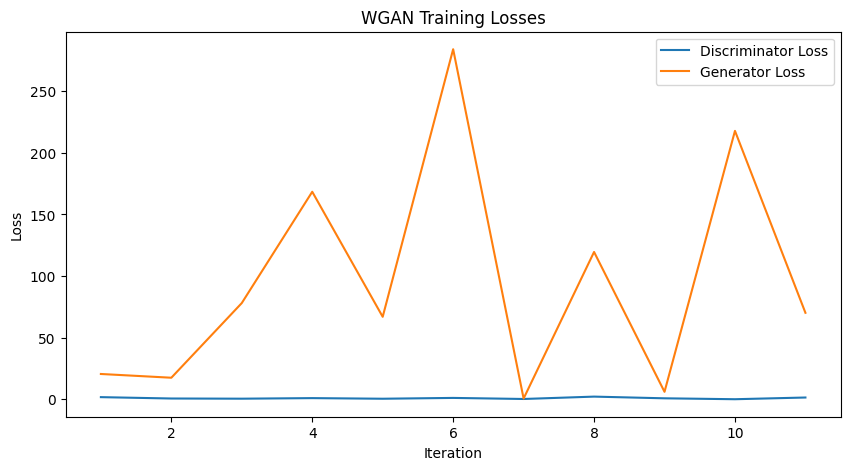

In [19]:
import matplotlib.pyplot as plt

# Create a list of iterations (assuming each print corresponds to an iteration)
iterations = list(range(1, len(losses_d) + 1))

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(iterations, losses_d, label='Discriminator Loss')
plt.plot(iterations, losses_g, label='Generator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('WGAN Training Losses')
plt.legend()
plt.show()
